# PSI for Earthquake

To run this tutorial, you need to install anaconda or miniconda and create a new environment. <br>
You can do this by running the following commands in terminal. <br>

`conda create -n cophileq python==3.12 pygmt obspy geopandas seaborn ipykernel`

Then activate the environment using <br>

`conda activate cophileq`

In Jupyter you can choose the cophil kernel to run the Jupyter notebooks.

In this tutorial, we will analyze the PSI deformation patterns before and after the  6.1Mw earthquake on 2019-04-22

In [6]:
# %% Step 0: Import Required Packages
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pygmt

In [7]:
# %% Step 1: Load Input Files

# Load the deformation points
des_df = pd.read_csv("S1a_desc_output.csv")
asc_df = pd.read_csv("S1b_asc_output.csv")

# Get element every nth point
n = 50  # Select every 50th point
des_df_sm = des_df.iloc[::n, :]
asc_df_sm = asc_df.iloc[::n, :]

#%% Choose only the velocity data

roi = [120.4, 121.6, 14.3, 15.1]

# Select only the LAT, LON and VEL columns
des_vel = des_df_sm[["LON", "LAT", "VEL"]]
asc_vel = asc_df_sm[["LON", "LAT", "VEL"]]

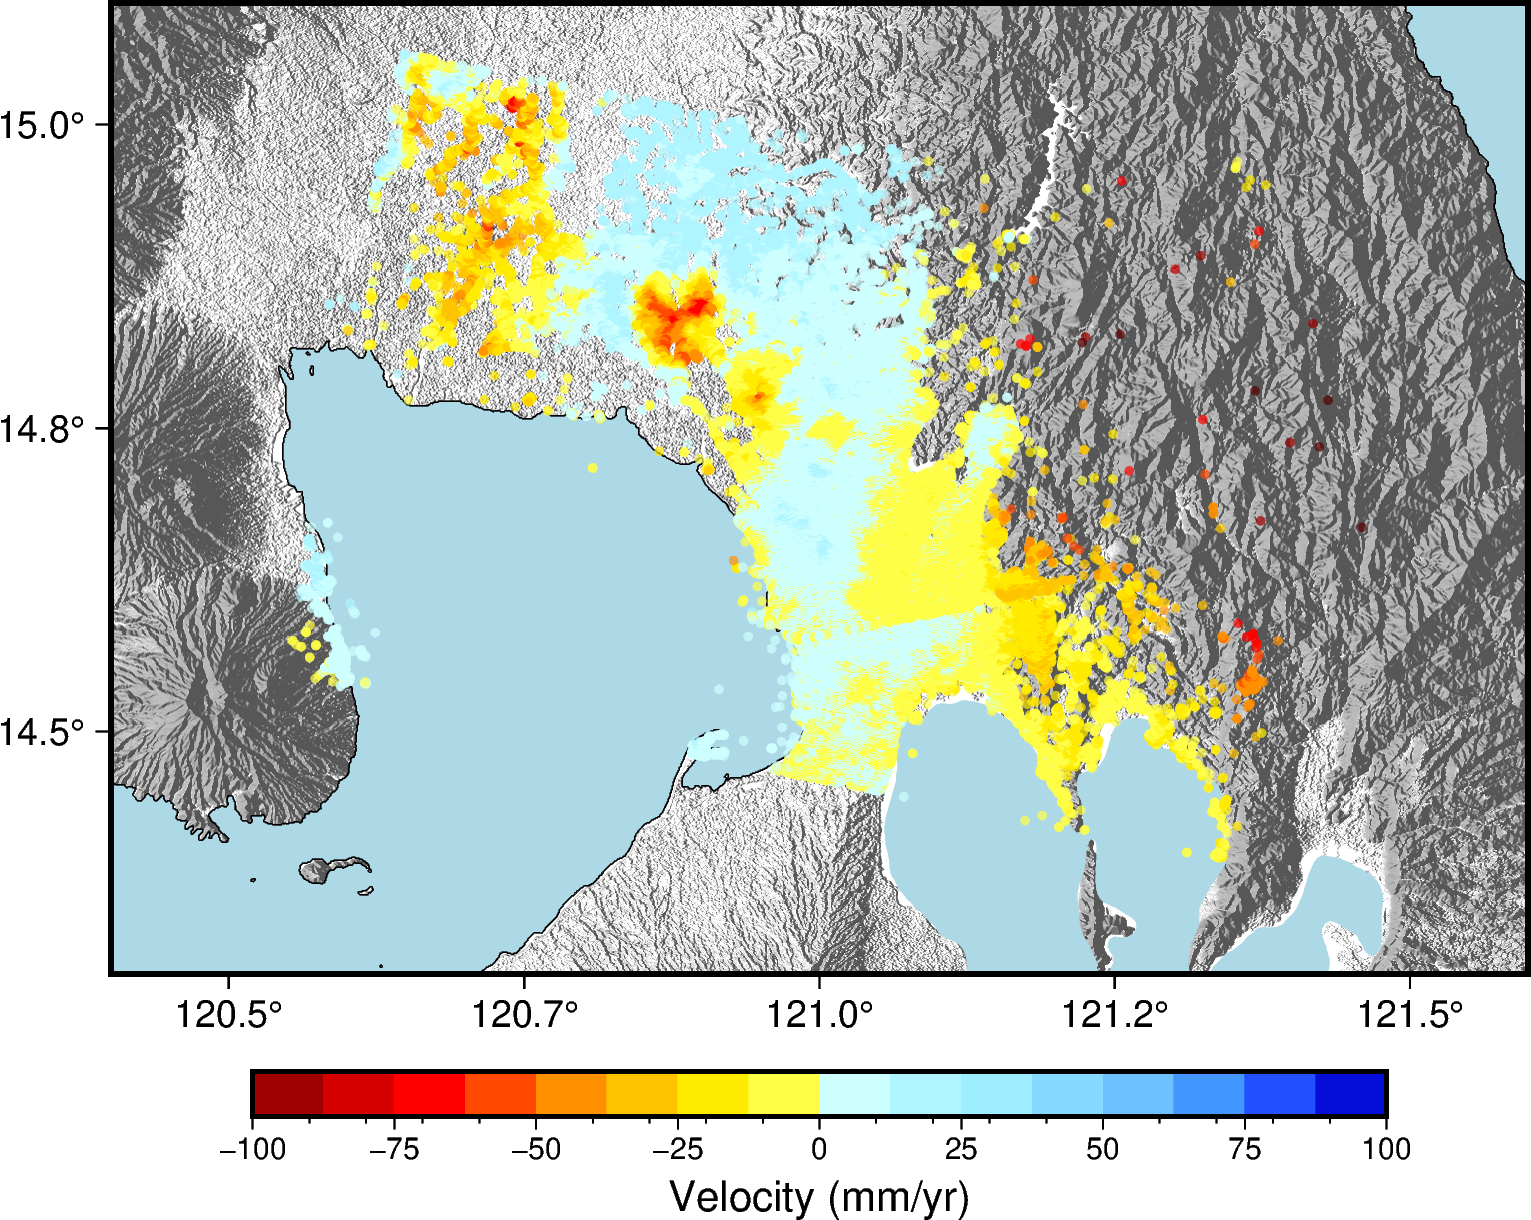

In [8]:
# Step 2: Plotting with PyGMT
fig = pygmt.Figure()

# Load sample grid (3 arc-seconds global relief) in target area
grid = pygmt.datasets.load_earth_relief(resolution="03s", region=roi)

# calculate the reflection of a light source projecting from west to east
# (azimuth of 270 degrees) and at a latitude of 30 degrees from the horizon
dgrid = pygmt.grdgradient(grid=grid, radiance=[270, 30])

# Define the projection
proj = "M12c"  # Mercator projection with a width of 12 cm
pygmt.config(FORMAT_GEO_MAP="ddd.x", MAP_FRAME_TYPE="plain")

pygmt.makecpt(cmap="gray", series=[-1.5, 0.1, 0.01])
fig.grdimage(
    grid=dgrid,
    projection="M12c",
    frame=["lSnWet+t", "xa2", "ya2"],
    cmap=True,
)

fig.grdimage(
    grid=dgrid,
    projection=proj,
    frame=["lSnWet+t", "xa2", "ya2"],
    cmap=True,
)

# Add coastlines, rivers, lakes, and borders
fig.coast(
    projection=proj,
    resolution="f",
    frame="a",
    water="lightblue",
    lakes="lightblue",
    rivers="1/0.25p,lightblue,solid",
    shorelines="1/0.25p,black",
    dcw="EG+p0.5p,steelblue",
)

#pygmt.makecpt(cmap="viridis", series=[-100, 100, 1],
#              continuous=True)
# Make CPT using des_vel and asc_vel "VEL" values
pygmt.makecpt(
    cmap="panoply",
#    series=[des_vel["VEL"].min(), des_vel["VEL"].max(), 0.01],
    series=[-100, 100], #[-100, 100, 0.01],
#    continuous=True,
    reverse =True
)

# Plot the descending points
fig.plot(
    x=des_vel["LON"],
    y=des_vel["LAT"],
    style="c0.075c",
    fill=des_vel["VEL"],
    cmap=True,
    transparency=30,
)

# Plot the ascending points
fig.plot(
    x=asc_vel["LON"],
    y=asc_vel["LAT"],
    style="c0.075c",
    fill=asc_vel["VEL"],
    cmap=True,
    transparency=30,
)

fig.colorbar(frame="xa25f+lVelocity (mm/yr)")

# Show the figure
fig.show()

In [9]:
#% Step 3: Extract Dates from DataFrames and Calculate Overall Start and End Dates
from datetime import datetime

# Get the coordinates of the deformation points
des_coords = des_df_sm[["LON", "LAT"]]
asc_coords = asc_df_sm[["LON", "LAT"]]

# Select only the columns with "D" at the beginning of the name
des_d_columns = [col for col in des_df_sm.columns if col.startswith("D")]
asc_d_columns = [col for col in asc_df_sm.columns if col.startswith("D")]

# Select only the columns with "D" at the beginning of the name
des_psi = des_coords.join(des_df_sm[des_d_columns])
asc_psi = asc_coords.join(asc_df_sm[asc_d_columns])

# Get the dates numeric values from the column names
des_dates = [col[1:] for col in des_d_columns]
asc_dates = [col[1:] for col in asc_d_columns]

# Convert the date strings to datetime objects
des_start_date =  min([datetime.strptime(date, "%Y%m%d") for date in des_dates])
des_end_date = max([datetime.strptime(date, "%Y%m%d") for date in des_dates])

asc_start_date = min([datetime.strptime(date, "%Y%m%d") for date in asc_dates])
asc_end_date = max([datetime.strptime(date, "%Y%m%d") for date in asc_dates])

# Get the overall start and end dates
overall_start_date = min(des_start_date, asc_start_date)
overall_end_date = max(des_end_date, asc_end_date)

# Print the overall start and end dates
print(f"Overall start date: {overall_start_date}")
print(f"Overall end date: {overall_end_date}")


Overall start date: 2019-01-02 00:00:00
Overall end date: 2020-12-24 00:00:00


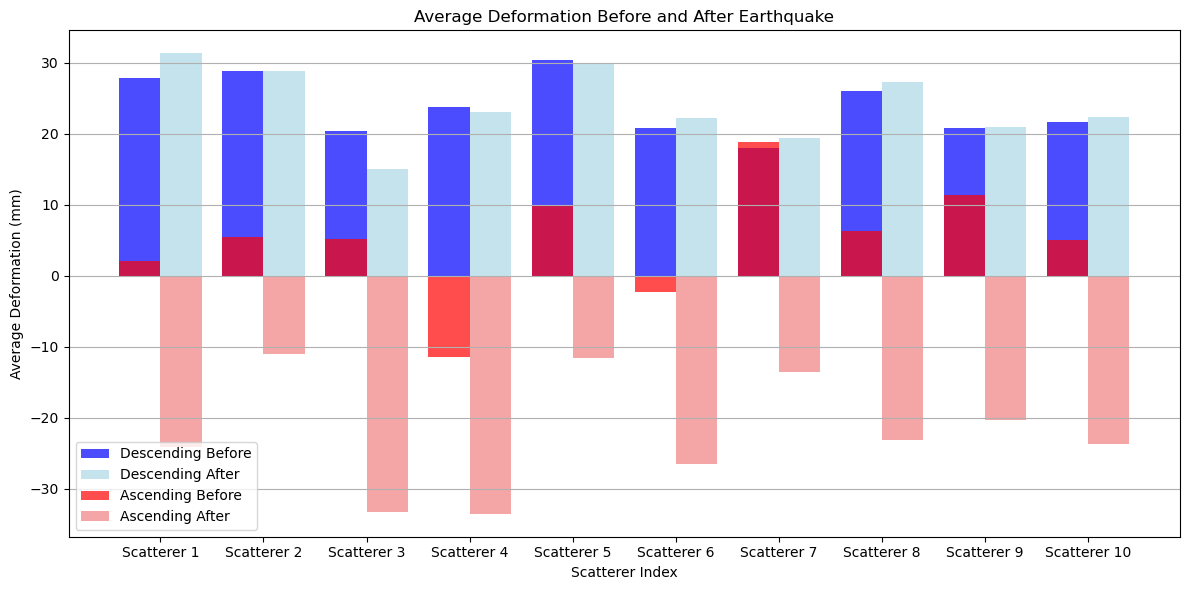

In [10]:
# Step 4: Calculate Average Deformation Before and After Earthquake

# Define the earthquake origin time
eq_origin_time = datetime(2019, 4, 22)  

# Get the average deformation before  and after the earthquke for the first 10 points
# Create a list of the name of the D columns and convert them to datetime objects
des_d_dates = [datetime.strptime(date, "%Y%m%d") for date in des_dates]
asc_d_dates = [datetime.strptime(date, "%Y%m%d") for date in asc_dates]

# Get the name of the D columns before the earthquake
des_d_before = [des_d_columns[i] for i, date in enumerate(des_d_dates) if date <= eq_origin_time]
asc_d_before = [asc_d_columns[i] for i, date in enumerate(asc_d_dates) if date <= eq_origin_time]

# Get the name of the D columns after the earthquake
des_d_after = [des_d_columns[i] for i, date in enumerate(des_d_dates) if date > eq_origin_time]
asc_d_after = [asc_d_columns[i] for i, date in enumerate(asc_d_dates) if date > eq_origin_time]

# Make a new dataframe with the average deformation before and after the earthquake
des_avg_before = des_psi[des_d_before].mean(axis=1)
asc_avg_before = asc_psi[asc_d_before].mean(axis=1)

des_avg_after = des_psi[des_d_after].mean(axis=1)
asc_avg_after = asc_psi[asc_d_after].mean(axis=1)

# Plot the average deformation before and after the earthquake for the first 10 points
plt.figure(figsize=(12, 6))
plt.bar(np.arange(10) - 0.2, des_avg_before[0:10], width=0.4, 
        label='Descending Before', color='blue', alpha=0.7)
plt.bar(np.arange(10) + 0.2, des_avg_after[0:10], width=0.4, 
        label='Descending After', color='lightblue', alpha=0.7)
plt.bar(np.arange(10) - 0.2, asc_avg_before[0:10], width=0.4, 
        label='Ascending Before', color='red', alpha=0.7)
plt.bar(np.arange(10) + 0.2, asc_avg_after[0:10], width=0.4, 
        label='Ascending After', color='lightcoral', alpha=0.7)
plt.xlabel('Scatterer Index')
plt.ylabel('Average Deformation (mm)')
plt.title('Average Deformation Before and After Earthquake')
plt.xticks(np.arange(10), [f'Scatterer {i+1}' for i in range(10)])
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Create a new dataframe with the D columns before the earthquake
des_psi_before = des_coords.join(des_df_sm[des_d_before])
asc_psi_before = asc_coords.join(asc_df_sm[asc_d_before])

# Add the average deformation before the earthquake to the dataframe
des_psi_before["VEL_before"] = des_avg_before
asc_psi_before["VEL_before"] = asc_avg_before

# Create a new dataframe with the D columns after the earthquake
des_psi_after = des_coords.join(des_df_sm[des_d_after])
asc_psi_after = asc_coords.join(asc_df_sm[asc_d_after])

# Add the average deformation after the earthquake to the dataframe
des_psi_after["VEL_after"] = des_avg_after
asc_psi_after["VEL_after"] = asc_avg_after

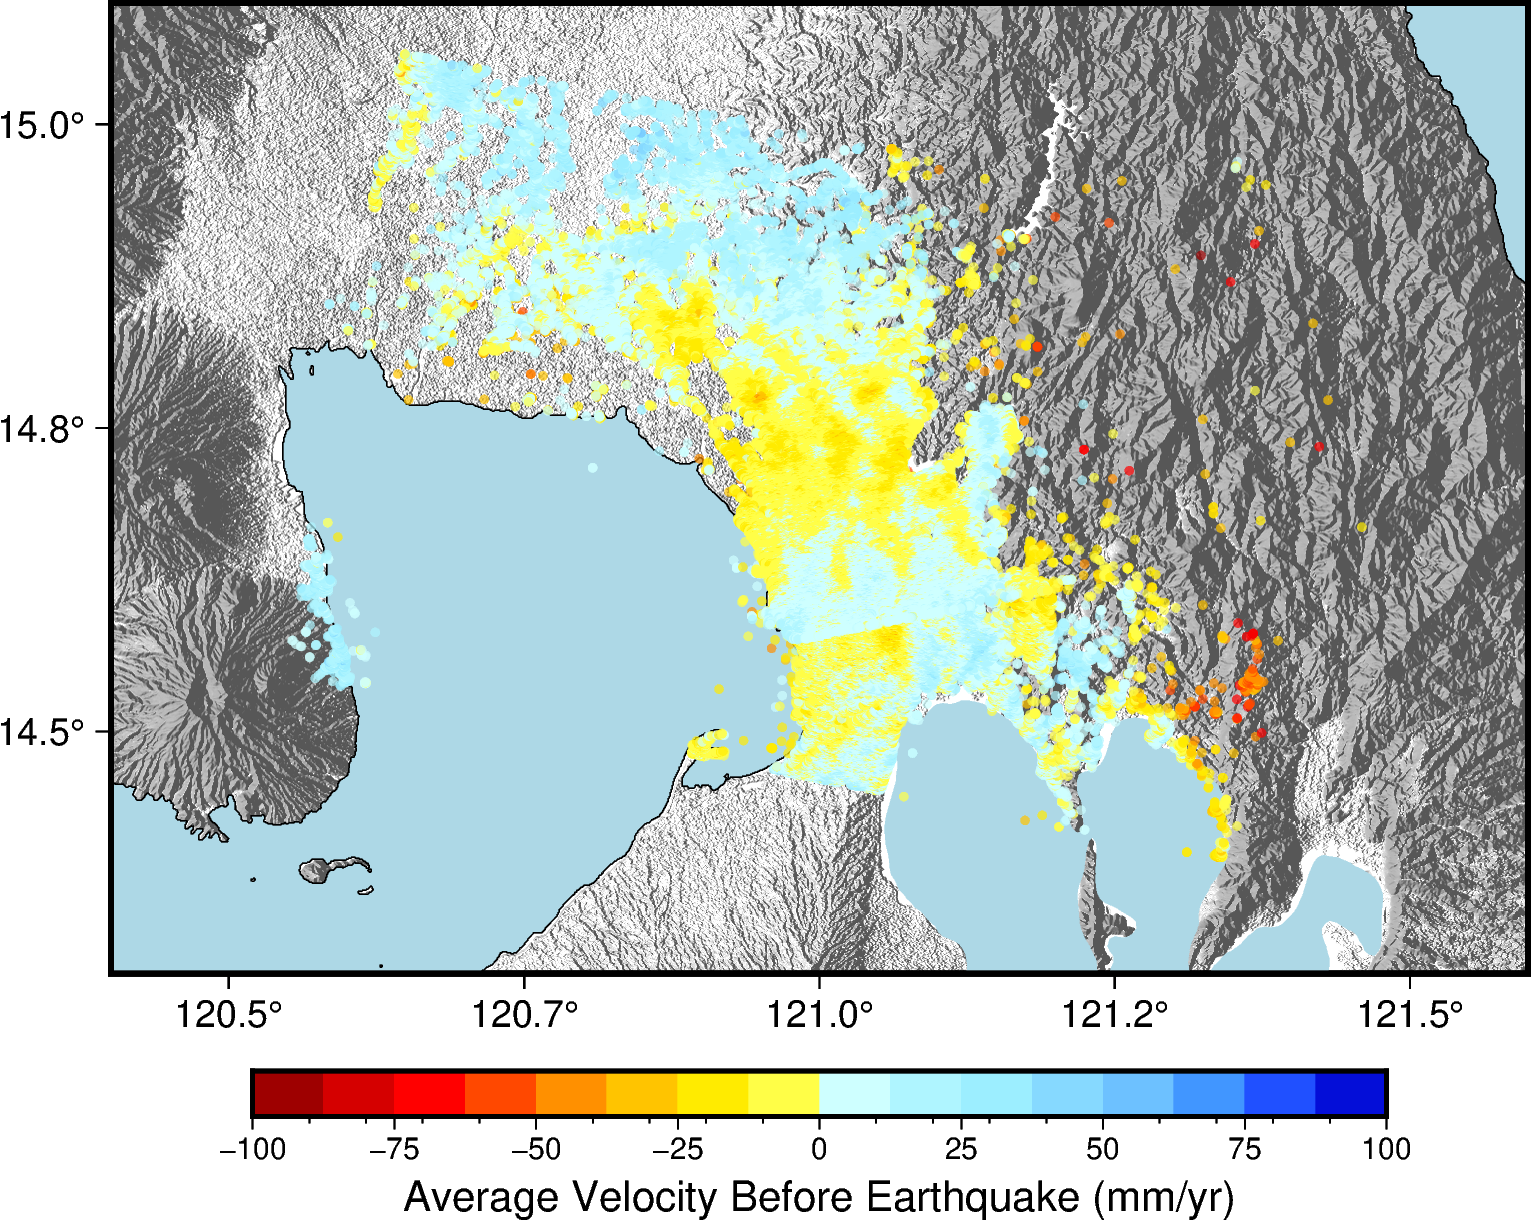

In [11]:
# Step 5: Plotting the Average Deformation Before and After Earthquake
fig = pygmt.Figure()

# Load sample grid (3 arc-seconds global relief) in target area
grid = pygmt.datasets.load_earth_relief(resolution="03s", region=roi)

# calculate the reflection of a light source projecting from west to east
# (azimuth of 270 degrees) and at a latitude of 30 degrees from the horizon
dgrid = pygmt.grdgradient(grid=grid, radiance=[270, 30])

# Define the projection
proj = "M12c"  # Mercator projection with a width of 12 cm
pygmt.config(FORMAT_GEO_MAP="ddd.x", MAP_FRAME_TYPE="plain")

pygmt.makecpt(cmap="gray", series=[-1.5, 0.1, 0.01])
fig.grdimage(
    grid=dgrid,
    projection="M12c",
    frame=["lSnWet+t", "xa2", "ya2"],
    cmap=True,
)

fig.grdimage(
    grid=dgrid,
    projection=proj,
    frame=["lSnWet+t", "xa2", "ya2"],
    cmap=True,
)

# Add coastlines, rivers, lakes, and borders
fig.coast(
    projection=proj,
    resolution="f",
    frame="a",
    water="lightblue",
    lakes="lightblue",
    rivers="1/0.25p,lightblue,solid",
    shorelines="1/0.25p,black",
    dcw="EG+p0.5p,steelblue",
)

#pygmt.makecpt(cmap="viridis", series=[-100, 100, 1],
#              continuous=True)
# Make CPT using des_vel and asc_vel "VEL" values
pygmt.makecpt(
    cmap="panoply",
#    series=[des_vel["VEL"].min(), des_vel["VEL"].max(), 0.01],
    series=[-100, 100], #[-100, 100, 0.01],
#    continuous=True,
    reverse =True
)

# Plot the descending points
fig.plot(
    x=des_psi_before["LON"],
    y=des_psi_before["LAT"],
    style="c0.075c",
    fill=des_psi_before["VEL_before"],
    cmap=True,
    transparency=30,
)

# Plot the ascending points
fig.plot(
    x=asc_psi_before["LON"],
    y=asc_psi_before["LAT"],
    style="c0.075c",
    fill=asc_psi_before["VEL_before"],
    cmap=True,
    transparency=30,
)

fig.colorbar(frame="xa25f+lAverage Velocity Before Earthquake (mm/yr)")

# Show the figure
fig.show()

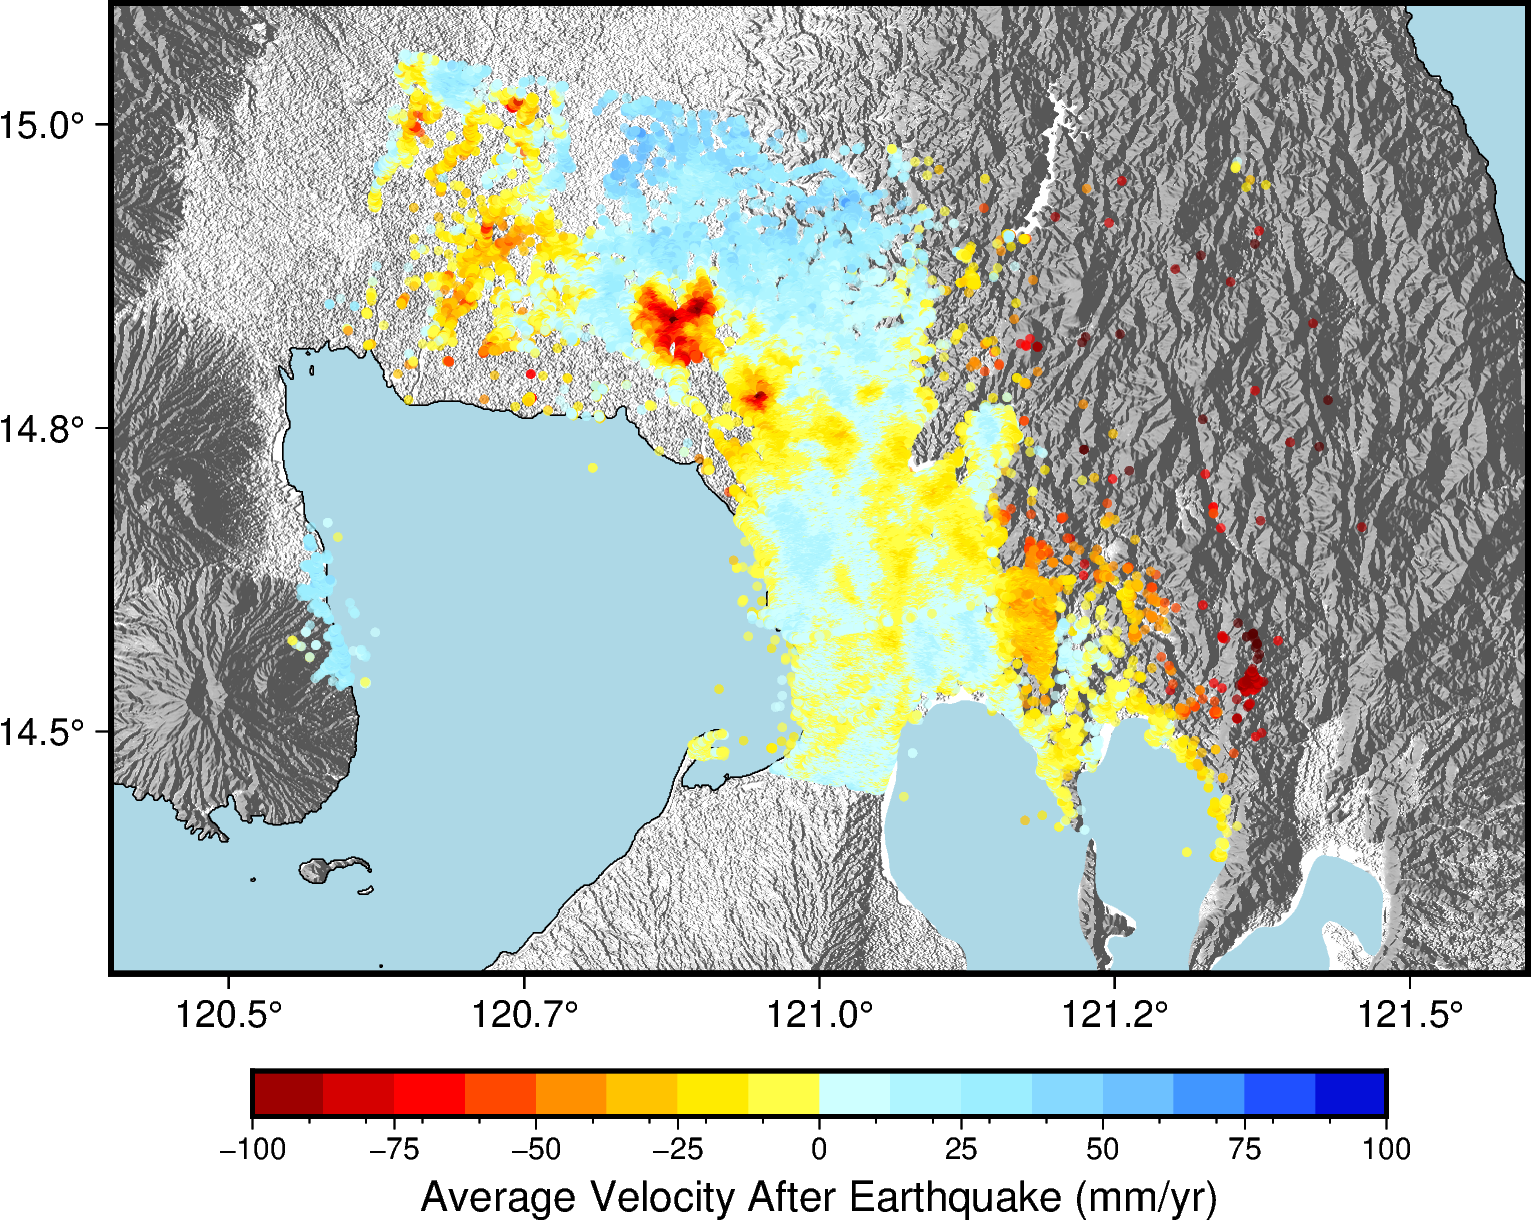

In [12]:
#%% Step 6: Plotting the Average Deformation After Earthquake
fig = pygmt.Figure()

# Load sample grid (3 arc-seconds global relief) in target area
grid = pygmt.datasets.load_earth_relief(resolution="03s", region=roi)

# calculate the reflection of a light source projecting from west to east
# (azimuth of 270 degrees) and at a latitude of 30 degrees from the horizon
dgrid = pygmt.grdgradient(grid=grid, radiance=[270, 30])

# Define the projection
proj = "M12c"  # Mercator projection with a width of 12 cm
pygmt.config(FORMAT_GEO_MAP="ddd.x", MAP_FRAME_TYPE="plain")

pygmt.makecpt(cmap="gray", series=[-1.5, 0.1, 0.01])
fig.grdimage(
    grid=dgrid,
    projection="M12c",
    frame=["lSnWet+t", "xa2", "ya2"],
    cmap=True,
)

fig.grdimage(
    grid=dgrid,
    projection=proj,
    frame=["lSnWet+t", "xa2", "ya2"],
    cmap=True,
)

# Add coastlines, rivers, lakes, and borders
fig.coast(
    projection=proj,
    resolution="f",
    frame="a",
    water="lightblue",
    lakes="lightblue",
    rivers="1/0.25p,lightblue,solid",
    shorelines="1/0.25p,black",
    dcw="EG+p0.5p,steelblue",
)

#pygmt.makecpt(cmap="viridis", series=[-100, 100, 1],
#              continuous=True)
# Make CPT using des_vel and asc_vel "VEL" values
pygmt.makecpt(
    cmap="panoply",
#    series=[des_vel["VEL"].min(), des_vel["VEL"].max(), 0.01],
    series=[-100, 100], #[-100, 100, 0.01],
#    continuous=True,
    reverse =True
)

# Plot the descending points
fig.plot(
    x=des_psi_after["LON"],
    y=des_psi_after["LAT"],
    style="c0.075c",
    fill=des_psi_after["VEL_after"],
    cmap=True,
    transparency=30,
)

# Plot the ascending points
fig.plot(
    x=asc_psi_after["LON"],
    y=asc_psi_after["LAT"],
    style="c0.075c",
    fill=asc_psi_after["VEL_after"],
    cmap=True,
    transparency=30,
)

fig.colorbar(frame="xa25f+lAverage Velocity After Earthquake (mm/yr)")

# Show the figure
fig.show()